In [1]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

In [2]:
path  = 'archive/real_vs_fake/real-vs-fake/'
dataset = {"image_path":[],"img_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.jpg"):
            dataset["image_path"].append(image)
            dataset["img_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,image_path,img_status,where
0,archive/real_vs_fake/real-vs-fake/test/fake\00...,fake,test
1,archive/real_vs_fake/real-vs-fake/test/fake\00...,fake,test
2,archive/real_vs_fake/real-vs-fake/test/fake\00...,fake,test
3,archive/real_vs_fake/real-vs-fake/test/fake\00...,fake,test
4,archive/real_vs_fake/real-vs-fake/test/fake\00...,fake,test
...,...,...,...
139995,archive/real_vs_fake/real-vs-fake/valid/real\6...,real,valid
139996,archive/real_vs_fake/real-vs-fake/valid/real\6...,real,valid
139997,archive/real_vs_fake/real-vs-fake/valid/real\6...,real,valid
139998,archive/real_vs_fake/real-vs-fake/valid/real\6...,real,valid


In [3]:
dataset.value_counts("img_status")

img_status
fake    70000
real    70000
dtype: int64

Real: 70000,
Fake: 70000



D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


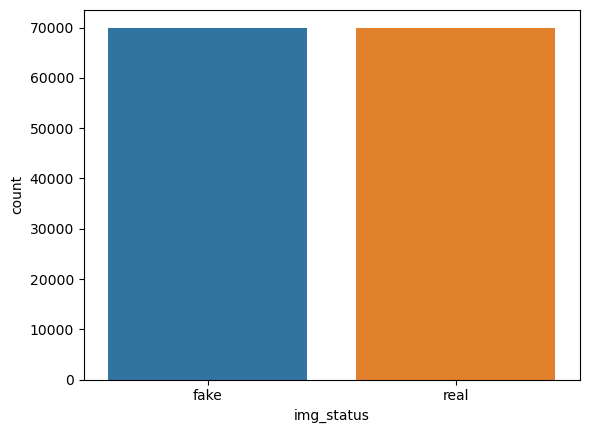

In [4]:
real = dataset.value_counts("img_status")[1]
fake = dataset.value_counts("img_status")[0]

print(f"Real: {real},\nFake: {fake}\n")
sns.countplot(dataset["img_status"])
plt.show()

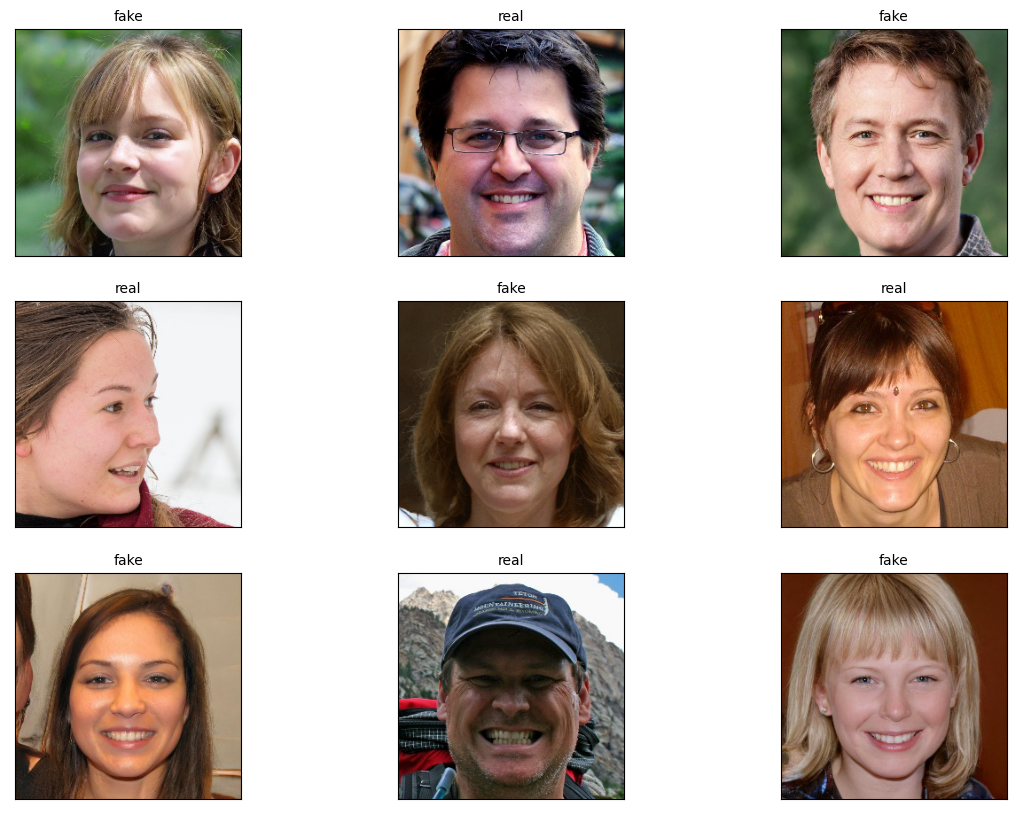

In [5]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(dataset))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(dataset.loc[random,"image_path"]))
    plt.title(dataset.loc[random, "img_status"], size = 10) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [6]:
image_gen = ImageDataGenerator()

In [7]:
train_generator = image_gen.flow_from_directory(
    path + 'train/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [8]:
valid_generator = image_gen.flow_from_directory(
    path + 'valid/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [9]:
test_generator = image_gen.flow_from_directory(
    path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [10]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )

In [11]:
model = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

In [12]:
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = valid_generator,
    validation_steps = (20000//100),
    epochs = 10
)

C:\Users\Aoishion\AppData\Local\Temp\ipykernel_10108\4136563541.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10


In [ ]:
losses = pd.DataFrame(model.history.history)

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes

In [ ]:
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [ ]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

In [ ]:
print(metrics.classification_report(y_test, y_pred > 0.5))